<a href="https://colab.research.google.com/github/am-nimrah/MachineLearning/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from inspect import signature



drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loading the data and target from the specified file paths
data_path = "/content/drive/MyDrive/cv_project/olivetti_faces.npy"
target_path = "/content/drive/MyDrive/cv_project/olivetti_faces_target.npy"

data = np.load(data_path)
target = np.load(target_path)

In [ ]:
# Get information about the dataset
num_images = len(data)
num_unique_targets = len(np.unique(target))
image_height, image_width = data.shape[1], data.shape[2]
first_image_pixel_values = data[0][0, :4]

In [ ]:
# Display the information
print("There are {} images in the dataset".format(num_images))
print("There are {} unique targets in the dataset".format(num_unique_targets))
print("Size of each image is {}x{}".format(image_height, image_width))
print("Pixel values were scaled to [0,1] interval. e.g: {}".format(first_image_pixel_values))


There are 400 images in the dataset
There are 40 unique targets in the dataset
Size of each image is 64x64
Pixel values were scaled to [0,1] interval. e.g: [0.30991736 0.3677686  0.41735536 0.44214877]


In [ ]:
def show_40_distinct_people(images, unique_ids):
    # Creating 4X10 subplots in 18x9 figure size
    fig, axarr = plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    # For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr = axarr.flatten()

    # Iterating over user ids
    for unique_id in unique_ids:
        image_index = unique_id * 10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
    plt.suptitle("There are 40 distinct people in the dataset")
    plt.show()

In [ ]:
def show_10_faces_of_n_subject(images, subject_ids):
    cols = 10  # each subject has 10 distinct face images
    rows = (len(subject_ids) * 10) // cols
    rows = int(rows)

    fig, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(18, 9))

    for i, subject_id in enumerate(subject_ids):
        for j in range(cols):
            image_index = subject_id * 10 + j
            axarr[i, j].imshow(images[image_index], cmap="gray")
            axarr[i, j].set_xticks([])
            axarr[i, j].set_yticks([])
            axarr[i, j].set_title("face id:{}".format(subject_id))
    plt.show()

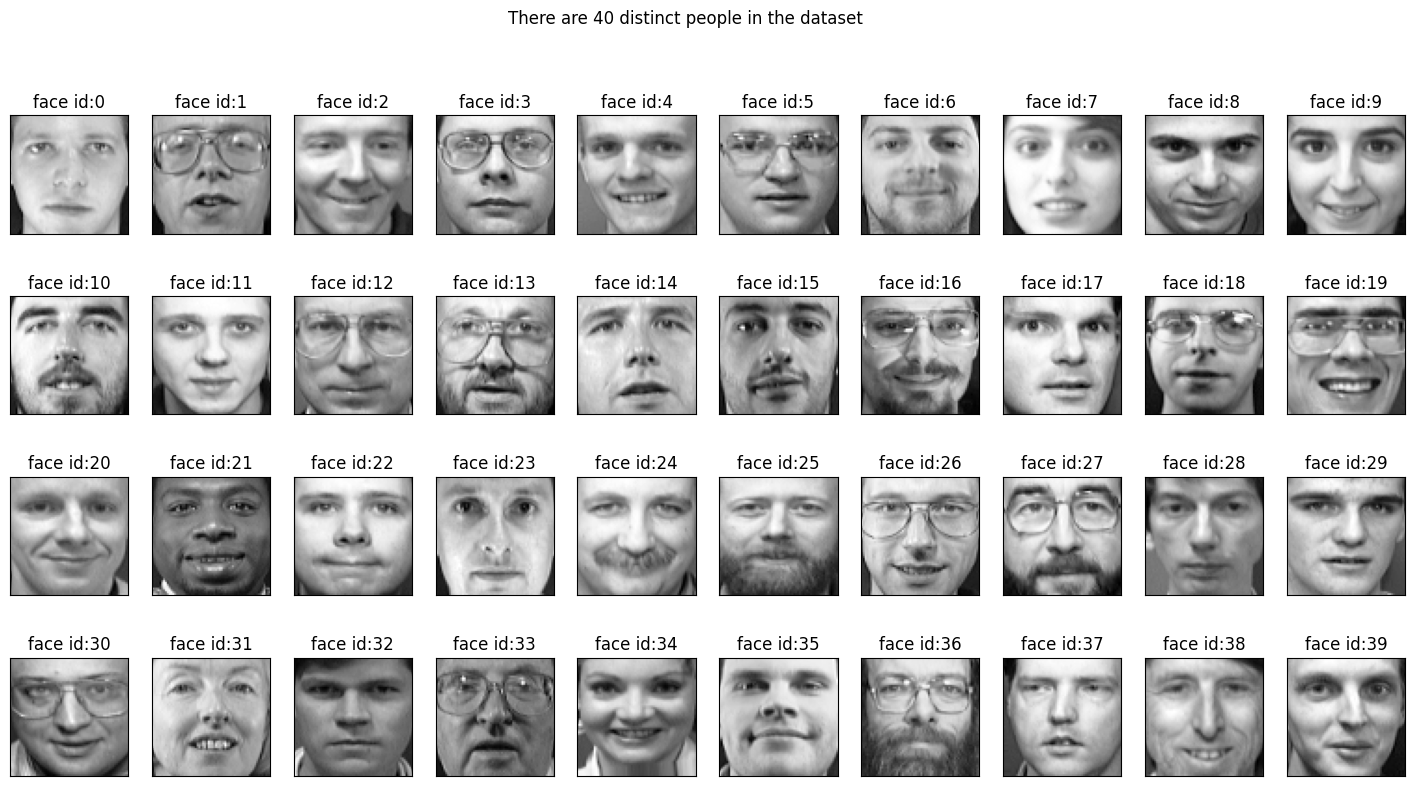

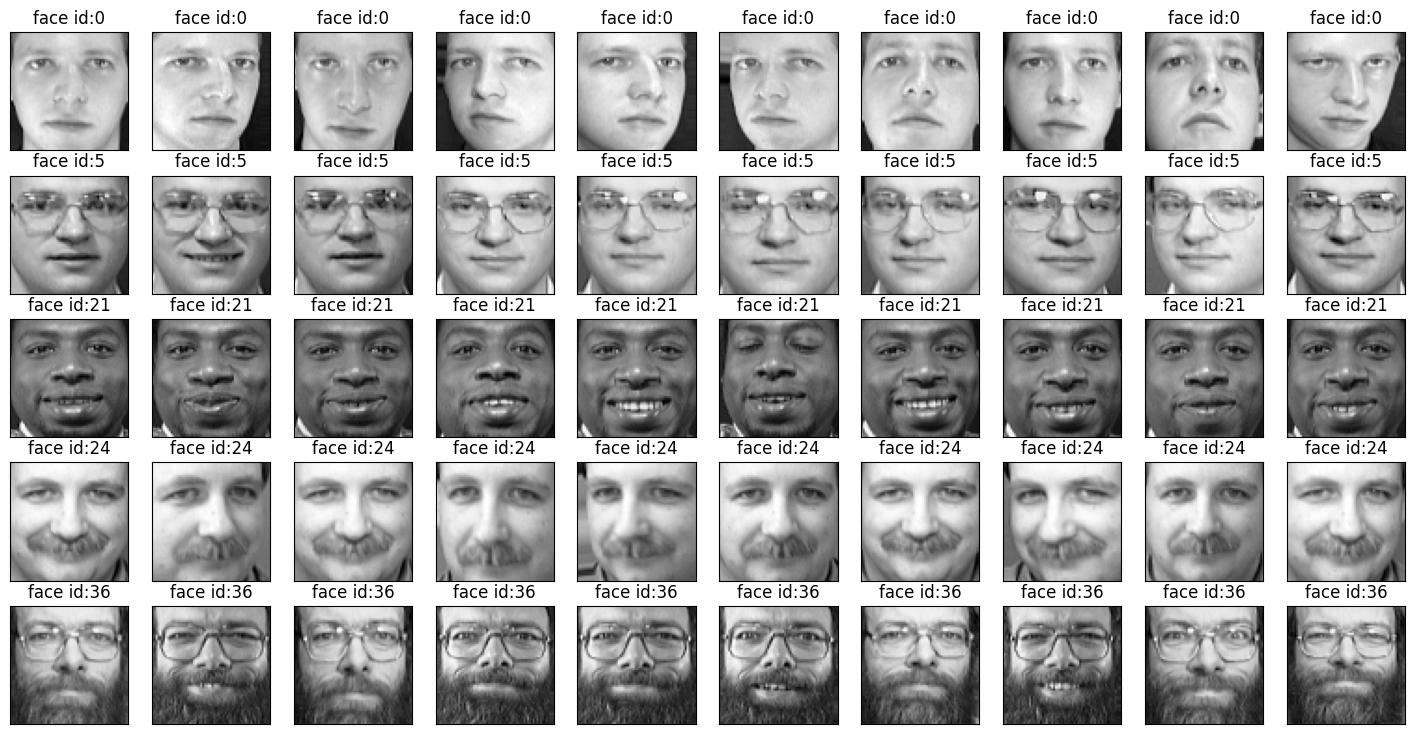

In [ ]:
show_40_distinct_people(data, np.unique(target))
show_10_faces_of_n_subject(images=data, subject_ids=[0, 5, 21, 24, 36])

In [ ]:
# We reshape images for machine learning model
X = data.reshape((data.shape[0], data.shape[1] * data.shape[2]))
print("X shape:", X.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.3, stratify=target, random_state=0)
print("X_train shape:", X_train.shape)
print("y_train shape:{}".format(y_train.shape))


X shape: (400, 4096)
X_train shape: (280, 4096)
y_train shape:(280,)


In [ ]:

# PCA
n_components = 90
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# SVM Classifier
clf = SVC()
clf.fit(X_train_pca, y_train)
y_pred = clf.predict(X_test_pca)

print("Accuracy score: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Classification Results:\n{}".format(classification_report(y_test, y_pred)))



Accuracy score: 0.92
Classification Results:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         3
           1       1.00      1.00      1.00         3
           2       0.50      0.67      0.57         3
           3       1.00      1.00      1.00         3
           4       1.00      0.67      0.80         3
           5       1.00      1.00      1.00         3
           6       1.00      0.67      0.80         3
           7       1.00      0.67      0.80         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      0.67      0.80         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       0.75      1.00      0.86         3
          16       1.00      1.00   

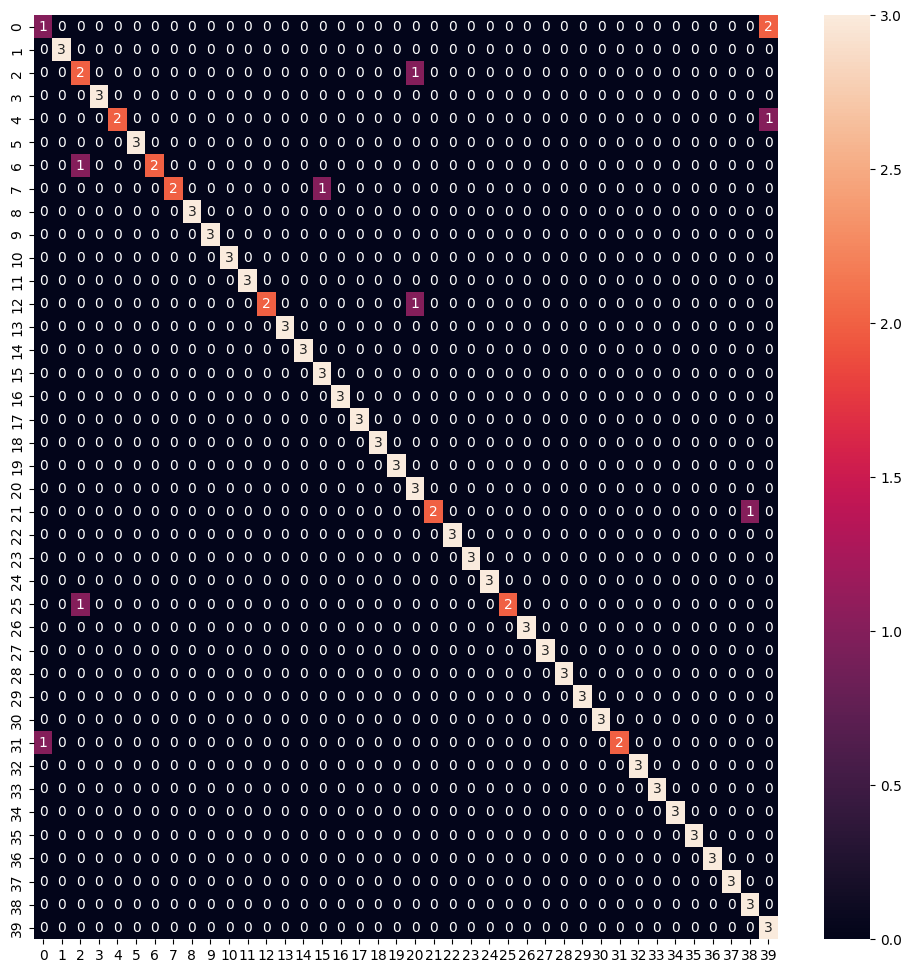

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.subplots(1, figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()


In [ ]:
# KFold Cross Validation
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR", LogisticRegression()))
models.append(("NB", GaussianNB()))
models.append(("KNN", KNeighborsClassifier(n_neighbors=5)))
models.append(("DT", DecisionTreeClassifier()))
models.append(("SVM", SVC()))

for name, model in models:
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = cross_val_score(model, X_train_pca, y_train, cv=kfold)
    print("{} mean cross-validation score: {:.2f}".format(name, cv_scores.mean()))


LDA mean cross-validation score: 0.95
LR mean cross-validation score: 0.85
NB mean cross-validation score: 0.53
KNN mean cross-validation score: 0.50
DT mean cross-validation score: 0.40
SVM mean cross-validation score: 0.65


In [ ]:
# One-vs-Rest Classifier
Target = label_binarize(target, classes=range(40))
n_classes = Target.shape[1]
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(
    X, Target, test_size=0.3, stratify=Target, random_state=0)

pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_multiclass)
X_train_multiclass_pca = pca.transform(X_train_multiclass)
X_test_multiclass_pca = pca.transform(X_test_multiclass)

oneRestClassifier = OneVsRestClassifier(LogisticRegression(C=1.0, penalty="l2"))
oneRestClassifier.fit(X_train_multiclass_pca, y_train_multiclass)
y_score = oneRestClassifier.decision_function(X_test_multiclass_pca)

precision = dict()
recall = dict()
average_precision = dict()


In [ ]:
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_multiclass[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test_multiclass[:, i], y_score[:, i])

In [ ]:
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_multiclass.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_multiclass, y_score, average="micro")

In [ ]:
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))


Average precision score, micro-averaged over all classes: 0.97


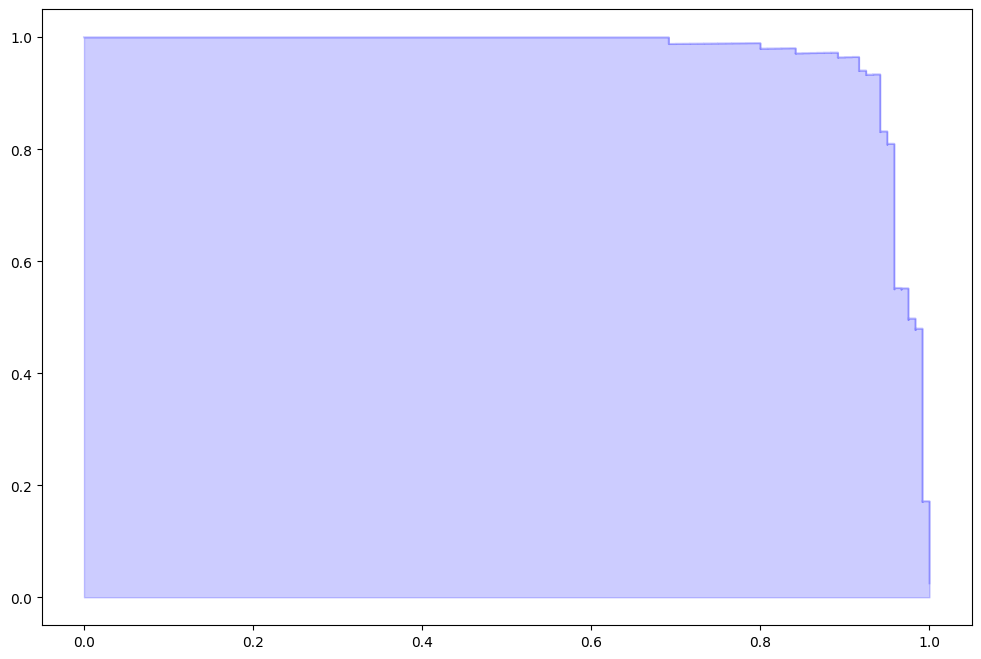

In [ ]:
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.figure(1, figsize=(12, 8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2, where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b', **step_kwargs)

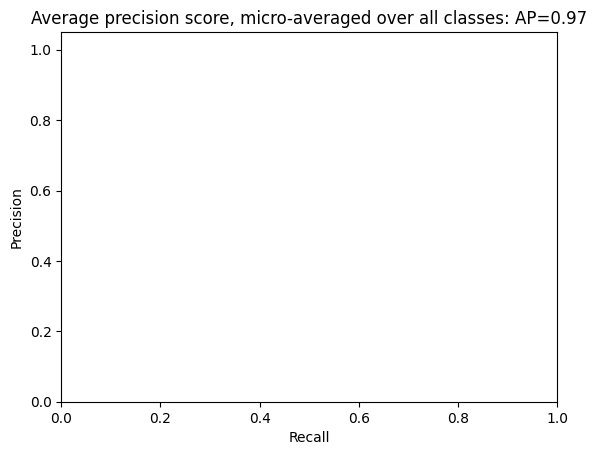

In [ ]:
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
plt.show()